In [69]:
#Import necesary libraries
!pip install heapq_max
!pip install pandas
!pip install numpy
!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np
import heapq

In [3]:
data = pd.read_csv("../data/ubicaciones.csv").drop("id_Agencia", axis = 1) # We drop id_Agencia because we know that there is only 1 id_Agencia in the dataset

In [4]:
data.head()

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon
0,1,1,2.0,20.506052,-98.212377
1,2,1,17.0,20.458128,-98.221248
2,3,1,2.0,20.530427,-98.236860
3,4,3,15.0,20.488655,-98.202940
4,5,1,2.0,20.533253,-98.219669


In [5]:
data['Frecuencia'].value_counts()

1    3299
2     300
3      26
Name: Frecuencia, dtype: int64

Process the data

In [6]:
id_clients_with_frequency_greater_than_1 = data[data['Frecuencia']>1]["Id_Cliente"]

In [7]:
data_wtih_replicated_rows = data.iloc[np.repeat(data.index.values,data['Frecuencia'])].reset_index(drop = True)

In [8]:
data_wtih_replicated_rows

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon
0,1,1,2.0,20.506052,-98.212377
1,2,1,17.0,20.458128,-98.221248
2,3,1,2.0,20.530427,-98.236860
3,4,3,15.0,20.488655,-98.202940
4,4,3,15.0,20.488655,-98.202940
...,...,...,...,...,...
3972,3622,1,2.0,20.541300,-98.157300
3973,3623,1,6.0,20.509200,-98.128000
3974,3624,1,31.0,20.513400,-98.154500
3975,3625,2,18.5,20.521772,-98.166209


In [9]:
from sklearn.cluster import KMeans

In [10]:
data_to_model_kmeans = data_wtih_replicated_rows[["lat","lon"]]

In [11]:
Kmeans_cluster = KMeans(n_clusters = 6,random_state=7)

In [12]:
clusters = Kmeans_cluster.fit(data_to_model_kmeans)

In [13]:
df_points_clasified = data_wtih_replicated_rows.copy()
df_points_clasified['Cluster'] = clusters.labels_

In [14]:
df_points_clasified

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster
0,1,1,2.0,20.506052,-98.212377,0
1,2,1,17.0,20.458128,-98.221248,1
2,3,1,2.0,20.530427,-98.236860,0
3,4,3,15.0,20.488655,-98.202940,1
4,4,3,15.0,20.488655,-98.202940,1
...,...,...,...,...,...,...
3972,3622,1,2.0,20.541300,-98.157300,4
3973,3623,1,6.0,20.509200,-98.128000,4
3974,3624,1,31.0,20.513400,-98.154500,4
3975,3625,2,18.5,20.521772,-98.166209,3


With this aproach we all the clients with frequency greater than 1 are clasified in the same cluster, we need to correct this, finding the next best cluster

In [15]:
data_clients_with_frequency_greater_than_1 = df_points_clasified[df_points_clasified['Id_Cliente'].isin(id_clients_with_frequency_greater_than_1)]


In [16]:
data_clients_with_frequency_greater_than_1

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster
3,4,3,15.0,20.488655,-98.202940,1
4,4,3,15.0,20.488655,-98.202940,1
5,4,3,15.0,20.488655,-98.202940,1
14,13,2,13.0,20.537454,-98.140527,4
15,13,2,13.0,20.537454,-98.140527,4
...,...,...,...,...,...,...
3924,3575,2,4.0,20.534023,-98.131136,4
3937,3588,2,17.0,20.478326,-98.242853,5
3938,3588,2,17.0,20.478326,-98.242853,5
3975,3625,2,18.5,20.521772,-98.166209,3


In [17]:
def find_n_closer_clusters(lat_input, lon_input, clusters, n = 2):
    dist_lon=(clusters[:,1]-lon_input)
    dist_lat=(clusters[:,0]-lat_input)
    distances_to_centroids =np.sqrt((dist_lon**2 + dist_lat**2))
    
    two_closer_clusters = heapq.nlargest(n, range(len(distances_to_centroids)), key=distances_to_centroids.__getitem__)
    return pd.Series(two_closer_clusters)


In [18]:
data_clients_with_frequency_greater_than_1[['ClosestCluster','SecondClosestCluster']] = data_clients_with_frequency_greater_than_1.apply(lambda x: find_n_closer_clusters(x['lat'],x['lon'],Kmeans_cluster.cluster_centers_),axis=1)


/Users/albertomandujano/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [19]:
data_clients_with_frequency_greater_than_1

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster,ClosestCluster,SecondClosestCluster
3,4,3,15.0,20.488655,-98.202940,1,4,5
4,4,3,15.0,20.488655,-98.202940,1,4,5
5,4,3,15.0,20.488655,-98.202940,1,4,5
14,13,2,13.0,20.537454,-98.140527,4,5,0
15,13,2,13.0,20.537454,-98.140527,4,5,0
...,...,...,...,...,...,...,...,...
3924,3575,2,4.0,20.534023,-98.131136,4,5,0
3937,3588,2,17.0,20.478326,-98.242853,5,4,2
3938,3588,2,17.0,20.478326,-98.242853,5,4,2
3975,3625,2,18.5,20.521772,-98.166209,3,5,0


In [20]:
data_clients_with_frequency_greater_than_1['FinalCluster']=-1

<ipython-input-20-849d77e403cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clients_with_frequency_greater_than_1['FinalCluster']=-1


In [21]:
last_Id_Cliente = 0
list_of_clusters = []
data_clients_with_frequency_greater_than_1['FinalCluster']=-1
for index, row in data_clients_with_frequency_greater_than_1.iterrows():
    current_Id_Cliente = row['Id_Cliente']
    if current_Id_Cliente != last_Id_Cliente:
        list_of_clusters = []
    if row['Cluster'] not in list_of_clusters:
        data_clients_with_frequency_greater_than_1.loc[index,'FinalCluster']=row['Cluster']
        list_of_clusters.append(row['Cluster'])
    elif row['ClosestCluster'] not in list_of_clusters:
        data_clients_with_frequency_greater_than_1.loc[index,'FinalCluster']=row['ClosestCluster']
        list_of_clusters.append(row['ClosestCluster'])
    else:
        data_clients_with_frequency_greater_than_1.loc[index,'FinalCluster']=row['SecondClosestCluster']
    last_Id_Cliente = current_Id_Cliente
        
        

<ipython-input-21-981225fdf2a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clients_with_frequency_greater_than_1['FinalCluster']=-1
/Users/albertomandujano/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:

data_clients_with_frequency_greater_than_1_corrected_clusters = data_clients_with_frequency_greater_than_1[['Id_Cliente','Frecuencia','Vol_Entrega','lat','lon','FinalCluster']].rename(columns = {"FinalCluster":"Cluster"})

id_replicated_clients = list(data_clients_with_frequency_greater_than_1_corrected_clusters['Id_Cliente'].values)


In [23]:
df_points_clasified_without_replicataed_clients = df_points_clasified[~df_points_clasified["Id_Cliente"].isin(id_replicated_clients)]



In [24]:
final_df_points_clasified_kmeans = pd.concat([df_points_clasified_without_replicataed_clients,data_clients_with_frequency_greater_than_1_corrected_clusters])

In [25]:
final_df_points_clasified_kmeans

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster
0,1,1,2.0,20.506052,-98.212377,0.0
1,2,1,17.0,20.458128,-98.221248,1.0
2,3,1,2.0,20.530427,-98.236860,0.0
6,5,1,2.0,20.533253,-98.219669,0.0
7,6,1,19.0,20.531060,-98.182642,3.0
...,...,...,...,...,...,...
3924,3575,2,4.0,20.534023,-98.131136,5.0
3937,3588,2,17.0,20.478326,-98.242853,5.0
3938,3588,2,17.0,20.478326,-98.242853,4.0
3975,3625,2,18.5,20.521772,-98.166209,3.0


In [26]:
final_df_points_clasified_kmeans.groupby('Cluster').agg(sum)

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon
Cluster,,,,,
0.0,680897,498,5484.666667,9193.384254,-44006.451353
1.0,1003964,678,9612.500000,12105.988415,-58035.222407
2.0,1121152,808,9327.166667,14027.075945,-67237.163993
3.0,1003060,668,7350.500000,12284.103198,-58716.118835
4.0,1853211,1106,11658.666667,18973.596377,-90693.259624
5.0,1163243,975,10966.500000,14975.222780,-71812.527278


In [27]:
def transformer_to_final_format(input_data):
    #this code asumes that input_data will have a column "Id_Cliente" and a column "Cluster"
    results_to_upload = input_data[['Id_Cliente','Cluster']]
    results_to_upload['Aux']=1
    wide_df = results_to_upload.pivot_table(index=["Id_Cliente"], 
                        columns='Cluster', 
                        values='Aux').fillna(0).reset_index()
    wide_df.columns = ["Id_Cliente","D1","D2","D3","D4","D5","D6"]
    return wide_df

In [28]:
result_kmeans = transformer_to_final_format(final_df_points_clasified_kmeans)
result_kmeans.to_csv("../Resultados/resultados_kmeans.csv", index = False)

<ipython-input-27-0b95aff8ad64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_to_upload['Aux']=1


In [29]:
final_df_points_clasified_kmeans

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster
0,1,1,2.0,20.506052,-98.212377,0.0
1,2,1,17.0,20.458128,-98.221248,1.0
2,3,1,2.0,20.530427,-98.236860,0.0
6,5,1,2.0,20.533253,-98.219669,0.0
7,6,1,19.0,20.531060,-98.182642,3.0
...,...,...,...,...,...,...
3924,3575,2,4.0,20.534023,-98.131136,5.0
3937,3588,2,17.0,20.478326,-98.242853,5.0
3938,3588,2,17.0,20.478326,-98.242853,4.0
3975,3625,2,18.5,20.521772,-98.166209,3.0


We graph the clusters

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling


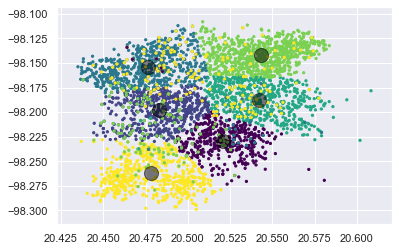

In [63]:
plt.scatter(final_df_points_clasified_kmeans['lat'], final_df_points_clasified_kmeans['lon'], c=final_df_points_clasified_kmeans['Cluster'], s=5, cmap='viridis')

centers = Kmeans_cluster.cluster_centers_
K_means_plot = plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
K_means_plot.get_figure().savefig('../Resultados/img/k_means_graph.pdf')

In [32]:
final_df_points_clasified_kmeans[['Cluster','Frecuencia','Vol_Entrega']].groupby("Cluster").agg(sum).reset_index()

,Cluster,Frecuencia,Vol_Entrega
0,0.0,498,5484.666667
1,1.0,678,9612.500000
2,2.0,808,9327.166667
3,3.0,668,7350.500000
4,4.0,1106,11658.666667
5,5.0,975,10966.500000


The K-Means aproach was a good start, but now, we will use the clusters found with the algorithm to draw the best routes, limiting the amount of Vol_Entrega and number of clients delivered.

In [33]:
optimal_volume =sum(data['Vol_Entrega'] * data['Frecuencia'])/6
optimal_deliveries = sum(data['Frecuencia'])/6
print(f"The optimal amount per day for Vol_entrega is {optimal_volume}")
print(f"The optimal amount per day for deliveries is {optimal_deliveries}")

The optimal amount per day for Vol_entrega is 9066.666666664667
The optimal amount per day for deliveries is 662.8333333333334


So we are going to draw routes to the closest client until we reach either of those metrics, and the start point will be each of the centroid found with K-Means

In [34]:
centroids = Kmeans_cluster.cluster_centers_
centroids

array([[ 20.5209192 , -98.22938923],
       [ 20.48292202, -98.19835822],
       [ 20.47621908, -98.15403333],
       [ 20.54181192, -98.18755836],
       [ 20.54352329, -98.14145633],
       [ 20.47829634, -98.2620625 ]])

We will use the raw data, and each time a delivery is made, we will subtract 1 from Frecuencia, if we reach 0 that client will be taken out from future deliveries

In [35]:
data_to_draw_routes_euclidean = data.copy()
data_to_draw_routes_haversine = data.copy()

In [36]:
def find_closest_client_euclidean(lat,lon, df_clients):
    dist_lat=(df_clients['lat']-lat)
    dist_lon=(df_clients['lon']-lon)
    distances =np.sqrt((dist_lon**2 + dist_lat**2))   
    next_client_in_route = df_clients.loc[distances.idxmin()][["Id_Cliente","Vol_Entrega","lat","lon"]]
    return next_client_in_route   
    

In [37]:
def find_closest_client_haversine(lat, lon, df_clients):
    df_clients['lat_rad'] = np.deg2rad(df_clients['lat'])
    df_clients['lon_rad'] = np.deg2rad(df_clients['lon'])
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)

    # haversine formula 
    dlon = lon_rad - df_clients['lon_rad']
    dlat = lat_rad - df_clients['lat_rad'] 
    a = np.sin(dlat/2)**2 + np.cos(lat_rad) * np.cos(lat_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    distances = c*r
    next_client_in_route = df_clients.loc[distances.idxmin()][["Id_Cliente","Vol_Entrega","lat","lon"]]
    return next_client_in_route

In [38]:
def frequency_checker(Id_client, df):
    df.loc[df['Id_Cliente'] == Id_client,'Frecuencia'] = df.loc[df['Id_Cliente'] == Id_client,'Frecuencia']-1
    data_filtered = df[df['Frecuencia']>0]
    return data_filtered

In [39]:
asigned_clusters_euclidean= {}
for i in range(1,7):
    asigned_clusters_euclidean["Cluster{0}".format(i)] = []

for cluster_number in np.arange(1,7):
    lat = centroids[1,][0]
    lon = centroids[1,][1]
    commulative_volume = 0
    commulative_deliveries = 0
    while((commulative_volume< optimal_volume) & (commulative_deliveries <optimal_deliveries)):
        valid_clients = data_to_draw_routes_euclidean[~data_to_draw_routes_euclidean['Id_Cliente'].isin(asigned_clusters_euclidean['Cluster{0}'.format(cluster_number)])]
        if valid_clients.shape[0] == 0:
            break
        next_client = find_closest_client_euclidean(lat,lon,valid_clients)
        commulative_volume = commulative_volume + next_client['Vol_Entrega']
        commulative_deliveries = commulative_deliveries + 1
        asigned_clusters_euclidean['Cluster{0}'.format(cluster_number)].append(next_client['Id_Cliente'])
        data_to_draw_routes_euclidean = frequency_checker(next_client['Id_Cliente'],data_to_draw_routes_euclidean)
        lat = next_client['lat']
        lon = next_client['lon']
        

In [40]:
asigned_clusters_haversine= {}
for i in range(1,7):
    asigned_clusters_haversine["Cluster{0}".format(i)] = []

for cluster_number in np.arange(1,7):
    lat = centroids[1,][0]
    lon = centroids[1,][1]
    commulative_volume = 0
    commulative_deliveries = 0
    while((commulative_volume< optimal_volume) & (commulative_deliveries <optimal_deliveries)):
        valid_clients = data_to_draw_routes_haversine[~data_to_draw_routes_haversine['Id_Cliente'].isin(asigned_clusters_euclidean['Cluster{0}'.format(cluster_number)])]
        if valid_clients.shape[0] == 0:
            break
        next_client = find_closest_client_haversine(lat,lon,valid_clients)
        commulative_volume = commulative_volume + next_client['Vol_Entrega']
        commulative_deliveries = commulative_deliveries + 1
        asigned_clusters_haversine['Cluster{0}'.format(cluster_number)].append(next_client['Id_Cliente'])
        data_to_draw_routes_haversine = frequency_checker(next_client['Id_Cliente'],data_to_draw_routes_haversine)
        lat = next_client['lat']
        lon = next_client['lon']
        

<ipython-input-37-8f278da8c80a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients['lat_rad'] = np.deg2rad(df_clients['lat'])
<ipython-input-37-8f278da8c80a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients['lon_rad'] = np.deg2rad(df_clients['lon'])


We check how well the clients are asigned to each cluster

In [41]:
clusters_to_check = asigned_clusters_haversine.copy()
unasigned_clients_to_check = data_to_draw_routes_haversine.copy()

In [42]:
clients_in_cluster_1 = asigned_clusters_haversine["Cluster1"]
data_clientes_in_cluster1 = data[data["Id_Cliente"].isin(clients_in_cluster_1)]

clients_in_cluster_2 = asigned_clusters_haversine["Cluster2"]
data_clientes_in_cluster2 = data[data["Id_Cliente"].isin(clients_in_cluster_2)]

clients_in_cluster_3 = asigned_clusters_haversine["Cluster3"]
data_clientes_in_cluster3 = data[data["Id_Cliente"].isin(clients_in_cluster_3)]

clients_in_cluster_4 = asigned_clusters_haversine["Cluster4"]
data_clientes_in_cluster4 = data[data["Id_Cliente"].isin(clients_in_cluster_4)]

clients_in_cluster_5 = asigned_clusters_haversine["Cluster5"]
data_clientes_in_cluster5 = data[data["Id_Cliente"].isin(clients_in_cluster_5)]

clients_in_cluster_6 = asigned_clusters_haversine["Cluster6"]
data_clientes_in_cluster6 = data[data["Id_Cliente"].isin(clients_in_cluster_6)]

final_drawing_routs = data[['Id_Cliente']].copy()
final_drawing_routs["D1"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_1),1,0)
final_drawing_routs["D2"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_2),1,0)
final_drawing_routs["D3"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_3),1,0)
final_drawing_routs["D4"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_4),1,0)
final_drawing_routs["D5"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_5),1,0)
final_drawing_routs["D6"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_6),1,0)

In [43]:
final_drawing_routs

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,0,0,0,0,1,0
1,2,0,0,0,0,1,0
2,3,0,0,0,0,1,0
3,4,0,0,1,0,0,0
4,5,0,0,0,0,1,0
...,...,...,...,...,...,...,...
3620,3621,0,0,0,1,0,0
3621,3622,0,0,0,0,1,0
3622,3623,0,0,0,0,0,1
3623,3624,0,0,1,0,0,0


In [44]:
final_drawing_routs.sum(axis = 1)
sc = final_drawing_routs[['Id_Cliente']]
sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)
test = sc.merge(data[["Id_Cliente","Frecuencia"]], on = "Id_Cliente") 
clients_to_asign = test[test["Frecuencia"]!= test["FrecAlg"]]

clients_to_asign["RemainingFrecuncias"] =clients_to_asign["Frecuencia"]-clients_to_asign["FrecAlg"]  


<ipython-input-44-e3c6912ef54b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)
<ipython-input-44-e3c6912ef54b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clients_to_asign["RemainingFrecuncias"] =clients_to_asign["Frecuencia"]-clients_to_asign["FrecAlg"]


In [45]:
clients_to_asign.reset_index(inplace = True, drop=True)
clients_to_asign_replicated = clients_to_asign.iloc[np.repeat(clients_to_asign.index.values,clients_to_asign['RemainingFrecuncias'])].reset_index(drop = True)
clients_to_asign_replicated


,Id_Cliente,FrecAlg,Frecuencia,RemainingFrecuncias
0,4,1,3,2
1,4,1,3,2
2,10,0,1,1
3,13,1,2,1
4,17,1,2,1
...,...,...,...,...
493,3575,0,2,2
494,3575,0,2,2
495,3588,1,2,1
496,3607,0,1,1


In [46]:

for client_to_asign in clients_to_asign_replicated['Id_Cliente']: 
    list_of_volumes = [sum(data_clientes_in_cluster1['Vol_Entrega']),
    sum(data_clientes_in_cluster2['Vol_Entrega']),
    sum(data_clientes_in_cluster3['Vol_Entrega']),
    sum(data_clientes_in_cluster4['Vol_Entrega']),
    sum(data_clientes_in_cluster5['Vol_Entrega']),
    sum(data_clientes_in_cluster6['Vol_Entrega']),
    ]

    list_of_deliveries = [
    data_clientes_in_cluster1.shape[0],
    data_clientes_in_cluster2.shape[0],
    data_clientes_in_cluster3.shape[0],
    data_clientes_in_cluster4.shape[0],
    data_clientes_in_cluster5.shape[0],
    data_clientes_in_cluster6.shape[0],
    ]

    list_of_lat = [np.mean(data_clientes_in_cluster1['lat']),
    np.mean(data_clientes_in_cluster2['lat']),
    np.mean(data_clientes_in_cluster3['lat']),
    np.mean(data_clientes_in_cluster4['lat']),
    np.mean(data_clientes_in_cluster5['lat']),
    np.mean(data_clientes_in_cluster6['lat']),
    ]

    list_of_lon = [np.mean(data_clientes_in_cluster1['lon']),
    np.mean(data_clientes_in_cluster2['lon']),
    np.mean(data_clientes_in_cluster3['lon']),
    np.mean(data_clientes_in_cluster4['lon']),
    np.mean(data_clientes_in_cluster5['lon']),
    np.mean(data_clientes_in_cluster6['lon']),
    ]

    lat_client = data[data['Id_Cliente']==client_to_asign]['lat'].iloc[0]
    lon_client = data[data['Id_Cliente']==client_to_asign]['lon'].iloc[0]

    distance_to_cluster =np.sqrt(((lat_client - list_of_lat)**2)+((lon_client - list_of_lon)**2))

    clusters_sorted_by_proximity = heapq.nlargest(6, range(len(distance_to_cluster)), key=distance_to_cluster.__getitem__)
    clusters_sorted_by_proximity=list(np.array(clusters_sorted_by_proximity) +1)
    for cluster in clusters_sorted_by_proximity:
        if client_to_asign in asigned_clusters_haversine['Cluster{0}'.format(cluster)]:
            continue
        volume_of_cluster = list_of_volumes[cluster-1]
        deliviries_of_cluster = list_of_deliveries[cluster-1]
        if ((volume_of_cluster< optimal_volume) & (deliviries_of_cluster <optimal_deliveries)):
            asigned_clusters_haversine['Cluster{0}'.format(cluster)].append(client_to_asign)
            break
        else:
            continue
            
    clients_in_cluster_1 = asigned_clusters_haversine["Cluster1"]
    data_clientes_in_cluster1 = data[data["Id_Cliente"].isin(clients_in_cluster_1)]

    clients_in_cluster_2 = asigned_clusters_haversine["Cluster2"]
    data_clientes_in_cluster2 = data[data["Id_Cliente"].isin(clients_in_cluster_2)]

    clients_in_cluster_3 = asigned_clusters_haversine["Cluster3"]
    data_clientes_in_cluster3 = data[data["Id_Cliente"].isin(clients_in_cluster_3)]

    clients_in_cluster_4 = asigned_clusters_haversine["Cluster4"]
    data_clientes_in_cluster4 = data[data["Id_Cliente"].isin(clients_in_cluster_4)]

    clients_in_cluster_5 = asigned_clusters_haversine["Cluster5"]
    data_clientes_in_cluster5 = data[data["Id_Cliente"].isin(clients_in_cluster_5)]

    clients_in_cluster_6 = asigned_clusters_haversine["Cluster6"]
    data_clientes_in_cluster6 = data[data["Id_Cliente"].isin(clients_in_cluster_6)]

In [47]:
final_drawing_routs = data[['Id_Cliente']].copy()
final_drawing_routs["D1"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_1),1,0)
final_drawing_routs["D2"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_2),1,0)
final_drawing_routs["D3"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_3),1,0)
final_drawing_routs["D4"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_4),1,0)
final_drawing_routs["D5"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_5),1,0)
final_drawing_routs["D6"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_6),1,0)
final_drawing_routs

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,0,0,0,0,1,0
1,2,0,0,0,0,1,0
2,3,0,0,0,0,1,0
3,4,1,0,1,1,0,0
4,5,0,0,0,0,1,0
...,...,...,...,...,...,...,...
3620,3621,0,0,0,1,0,0
3621,3622,0,0,0,0,1,0
3622,3623,0,0,0,0,0,1
3623,3624,0,0,1,0,0,0


In [49]:
final_drawing_routs.sum(axis = 1)
sc = final_drawing_routs[['Id_Cliente']]
sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)
test = sc.merge(data[["Id_Cliente","Frecuencia"]], on = "Id_Cliente") 
remeingn_clients = test[test["Frecuencia"]!= test["FrecAlg"]]
remeingn_clients['RemainingFrecuncias'] = remeingn_clients['Frecuencia']-remeingn_clients['FrecAlg']
remeingn_clients

<ipython-input-49-bfb79b33a9be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)
<ipython-input-49-bfb79b33a9be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remeingn_clients['RemainingFrecuncias'] = remeingn_clients['Frecuencia']-remeingn_clients['FrecAlg']


,Id_Cliente,FrecAlg,Frecuencia,RemainingFrecuncias
1883,1884,0,1,1
1904,1905,1,2,1
1919,1920,0,1,1
1976,1977,1,2,1
2001,2002,0,1,1
...,...,...,...,...
3562,3563,0,1,1
3574,3575,0,2,2
3587,3588,1,2,1
3606,3607,0,1,1


We have clients that need to be assigned to another cluster

In [50]:

clients_to_asign_replicated = remeingn_clients.loc[np.repeat(remeingn_clients.index.values,remeingn_clients['RemainingFrecuncias'])].reset_index(drop = True)
clients_to_asign_replicated



,Id_Cliente,FrecAlg,Frecuencia,RemainingFrecuncias
0,1884,0,1,1
1,1905,1,2,1
2,1920,0,1,1
3,1977,1,2,1
4,2002,0,1,1
...,...,...,...,...
127,3575,0,2,2
128,3575,0,2,2
129,3588,1,2,1
130,3607,0,1,1


In [51]:

for client_to_asign in clients_to_asign_replicated['Id_Cliente']: 
    list_of_volumes = [sum(data_clientes_in_cluster1['Vol_Entrega']),
    sum(data_clientes_in_cluster2['Vol_Entrega']),
    sum(data_clientes_in_cluster3['Vol_Entrega']),
    sum(data_clientes_in_cluster4['Vol_Entrega']),
    sum(data_clientes_in_cluster5['Vol_Entrega']),
    sum(data_clientes_in_cluster6['Vol_Entrega']),
    ]

    list_of_deliveries = [
    data_clientes_in_cluster1.shape[0],
    data_clientes_in_cluster2.shape[0],
    data_clientes_in_cluster3.shape[0],
    data_clientes_in_cluster4.shape[0],
    data_clientes_in_cluster5.shape[0],
    data_clientes_in_cluster6.shape[0],
    ]

    list_of_lat = [np.mean(data_clientes_in_cluster1['lat']),
    np.mean(data_clientes_in_cluster2['lat']),
    np.mean(data_clientes_in_cluster3['lat']),
    np.mean(data_clientes_in_cluster4['lat']),
    np.mean(data_clientes_in_cluster5['lat']),
    np.mean(data_clientes_in_cluster6['lat']),
    ]

    list_of_lon = [np.mean(data_clientes_in_cluster1['lon']),
    np.mean(data_clientes_in_cluster2['lon']),
    np.mean(data_clientes_in_cluster3['lon']),
    np.mean(data_clientes_in_cluster4['lon']),
    np.mean(data_clientes_in_cluster5['lon']),
    np.mean(data_clientes_in_cluster6['lon']),
    ]

    lat_client = data[data['Id_Cliente']==client_to_asign]['lat'].iloc[0]
    lon_client = data[data['Id_Cliente']==client_to_asign]['lon'].iloc[0]

    distance_to_cluster =np.sqrt(((lat_client - list_of_lat)**2)+((lon_client - list_of_lon)**2))

    clusters_sorted_by_proximity = heapq.nlargest(6, range(len(distance_to_cluster)), key=distance_to_cluster.__getitem__)
    clusters_sorted_by_proximity=list(np.array(clusters_sorted_by_proximity) +1)
    for cluster in clusters_sorted_by_proximity:
        if client_to_asign in asigned_clusters_haversine['Cluster{0}'.format(cluster)]:
            continue
        volume_of_cluster = list_of_volumes[cluster-1]
        deliviries_of_cluster = list_of_deliveries[cluster-1]
        if ((volume_of_cluster< 10100) & (deliviries_of_cluster <700)):
            asigned_clusters_haversine['Cluster{0}'.format(cluster)].append(client_to_asign)
            break
        else:
            continue
            
    clients_in_cluster_1 = asigned_clusters_haversine["Cluster1"]
    data_clientes_in_cluster1 = data[data["Id_Cliente"].isin(clients_in_cluster_1)]

    clients_in_cluster_2 = asigned_clusters_haversine["Cluster2"]
    data_clientes_in_cluster2 = data[data["Id_Cliente"].isin(clients_in_cluster_2)]

    clients_in_cluster_3 = asigned_clusters_haversine["Cluster3"]
    data_clientes_in_cluster3 = data[data["Id_Cliente"].isin(clients_in_cluster_3)]

    clients_in_cluster_4 = asigned_clusters_haversine["Cluster4"]
    data_clientes_in_cluster4 = data[data["Id_Cliente"].isin(clients_in_cluster_4)]

    clients_in_cluster_5 = asigned_clusters_haversine["Cluster5"]
    data_clientes_in_cluster5 = data[data["Id_Cliente"].isin(clients_in_cluster_5)]

    clients_in_cluster_6 = asigned_clusters_haversine["Cluster6"]
    data_clientes_in_cluster6 = data[data["Id_Cliente"].isin(clients_in_cluster_6)]

In [52]:
data_clientes_in_cluster1['Cluster']=1
data_clientes_in_cluster2['Cluster']=2
data_clientes_in_cluster3['Cluster']=3
data_clientes_in_cluster4['Cluster']=4
data_clientes_in_cluster5['Cluster']=5
data_clientes_in_cluster6['Cluster']=6

data_clientes_in_cluster_final = pd.concat([data_clientes_in_cluster1,data_clientes_in_cluster2,
                                           data_clientes_in_cluster3,data_clientes_in_cluster4,
                                           data_clientes_in_cluster5,data_clientes_in_cluster6])
data_clientes_in_cluster_final

<ipython-input-52-3e2d89d0a3a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clientes_in_cluster1['Cluster']=1
<ipython-input-52-3e2d89d0a3a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clientes_in_cluster2['Cluster']=2
<ipython-input-52-3e2d89d0a3a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,Id_Cliente,Frecuencia,Vol_Entrega,lat,lon,Cluster
3,4,3,15.0,20.488655,-98.202940,1
12,13,2,13.0,20.537454,-98.140527,1
13,14,1,17.0,20.523875,-98.238248,1
18,19,1,11.0,20.547675,-98.130903,1
21,22,2,12.0,20.534294,-98.163798,1
...,...,...,...,...,...,...
3593,3594,1,2.0,20.530200,-98.144700,6
3611,3612,1,5.0,20.546699,-98.139006,6
3613,3614,1,2.0,20.532000,-98.127800,6
3617,3618,1,1.0,20.476400,-98.168600,6


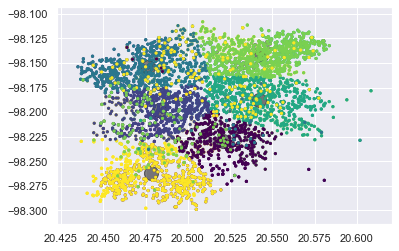

In [64]:
plt.scatter(data_clientes_in_cluster_final['lat'], data_clientes_in_cluster_final['lon'], c=data_clientes_in_cluster_final['Cluster'], s=5, cmap='viridis')

centers = Kmeans_cluster.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

route_drawing_plot = plt.scatter(final_df_points_clasified_kmeans['lat'], final_df_points_clasified_kmeans['lon'], c=final_df_points_clasified_kmeans['Cluster'], s=5, cmap='viridis')

route_drawing_plot.get_figure().savefig('../Resultados/img/route_drawing_plot.pdf')




In [54]:
final_drawing_routs = data[['Id_Cliente']].copy()
final_drawing_routs["D1"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_1),1,0)
final_drawing_routs["D2"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_2),1,0)
final_drawing_routs["D3"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_3),1,0)
final_drawing_routs["D4"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_4),1,0)
final_drawing_routs["D5"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_5),1,0)
final_drawing_routs["D6"] = np.where(final_drawing_routs['Id_Cliente'].isin(clients_in_cluster_6),1,0)
final_drawing_routs

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,0,0,0,0,1,0
1,2,0,0,0,0,1,0
2,3,0,0,0,0,1,0
3,4,1,0,1,1,0,0
4,5,0,0,0,0,1,0
...,...,...,...,...,...,...,...
3620,3621,0,0,0,1,0,0
3621,3622,0,0,0,0,1,0
3622,3623,0,0,0,0,0,1
3623,3624,0,0,1,0,0,0


In [55]:
final_drawing_routs.sum(axis = 1)
sc = final_drawing_routs[['Id_Cliente']]
sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)
test = sc.merge(data[["Id_Cliente","Frecuencia"]], on = "Id_Cliente") 
remeingn_clients = test[test["Frecuencia"]!= test["FrecAlg"]]
remeingn_clients['RemainingFrecuncias'] = remeingn_clients['Frecuencia']-remeingn_clients['FrecAlg']
remeingn_clients

<ipython-input-55-bfb79b33a9be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc['FrecAlg']=final_drawing_routs.loc[:, final_drawing_routs.columns != 'Id_Cliente'].sum(axis = 1)


,Id_Cliente,FrecAlg,Frecuencia,RemainingFrecuncias


In [56]:
#clients_to_asign_replicated=clients_to_asign_replicated.head()
list_of_volumes = [sum(data_clientes_in_cluster1['Vol_Entrega']),
    sum(data_clientes_in_cluster2['Vol_Entrega']),
    sum(data_clientes_in_cluster3['Vol_Entrega']),
    sum(data_clientes_in_cluster4['Vol_Entrega']),
    sum(data_clientes_in_cluster5['Vol_Entrega']),
    sum(data_clientes_in_cluster6['Vol_Entrega']),
    ]

list_of_deliveries = [
    data_clientes_in_cluster1.shape[0],
    data_clientes_in_cluster2.shape[0],
    data_clientes_in_cluster3.shape[0],
    data_clientes_in_cluster4.shape[0],
    data_clientes_in_cluster5.shape[0],
    data_clientes_in_cluster6.shape[0],
    ]

In [57]:
list_of_volumes

[10008.333333323,
 9264.166666656,
 9119.500000003,
 8680.99999999,
 8212.666666673,
 9114.333333343]

In [58]:
list_of_deliveries

[700, 689, 570, 688, 680, 650]

In [59]:
results_route_drawing = pd.DataFrame(list_of_volumes,list_of_deliveries).reset_index().reset_index()
results_route_drawing.columns = ['Cluster','Frecuencia','Vol_entrega']
results_route_drawing

,Cluster,Frecuencia,Vol_entrega
0,0,700,10008.333333
1,1,689,9264.166667
2,2,570,9119.500000
3,3,688,8681.000000
4,4,680,8212.666667
5,5,650,9114.333333


In [60]:
final_drawing_routs.to_csv("../Resultados/resultadosdrawing_haversine.csv", index = False)